In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing libs
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda,Dense, GaussianNoise
from keras.models import Model
from keras import regularizers
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
import random as rn

In [ ]:
# defining parameters
n = 128 
Mmod= 16
R = 0.5
kmod= int(np.log2(Mmod))
n_coded = n*kmod
k=int(n_coded*R)
N=100000
print ('k:',k,'n_coded:',n_coded,'n:',n,'R:',R,'M_mod:',Mmod)

k: 256 n_coded: 512 n: 128 R: 0.5 M_mod: 16


In [ ]:
data=np.random.randint(0,2,size=(N,k))
val_data=np.random.randint(0,2,size=((200000,k)))

In [ ]:
#data = np.array(data)
print (data.shape)

(4000000, 64)


In [ ]:
lr=0.0001
Eb_N0db=2
Eb_N0=10.0**(Eb_N0db/10.0)

In [ ]:
# defining autoencoder and it's layer
input_signal = Input(shape=(k,))
encoded = Dense(n_coded, activation='elu')(input_signal)
encoded1 = Dense(2*n, activation='linear')(encoded)
encoded2 = Dense(2*n, activation='elu')(encoded1)
encoded3 = Dense(2*n, activation='linear')(encoded2)

encoded4 = Lambda(lambda x: x / K.sqrt(K.mean(x**2)))(encoded3) #average power constraint
#encoded4 = BatchNormalization(momentum=0, center=False, scale=False)(encoded3)
#encoded4 = encoded3 / tf.sqrt(tf.reduce_mean(tf.square(encoded3)))
#encoded4 = Lambda(lambda x: x / K.sqrt(K.sum(x**2)/n))(encoded3) 
#encoded4 = Lambda(lambda x: np.sqrt(n)*K.l2_normalize(x,axis=1))(encoded3)
#encoded4 = Lambda(lambda x: (n_coded**0.5) * (x / LA.norm(x,axis=1)[:, None]))(encoded3)


encoded5 = GaussianNoise(np.sqrt(1/(2*R*kmod*Eb_N0)))(encoded4)
#encoded5 = GaussianNoise(np.sqrt(0.5))(encoded4)


decoded = Dense(2*n, activation='elu')(encoded5)
decoded1 = Dense(n_coded, activation='linear')(decoded)
decoded2 = Dense(k, activation='sigmoid')(decoded1)

autoencoder = Model(input_signal, decoded2)
adam = Adam(lr)
#adagrad=Adagrad(lr)
autoencoder.compile(optimizer=adam, loss='binary_crossentropy')

In [ ]:
print (autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
lambda_1 (Lambda)            (None, 256)               0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 256)               0   

In [ ]:
autoencoder.fit(data, data,
                epochs=100,
                shuffle=True,
                batch_size=2000,
                validation_data=(val_data, val_data))

Text(0.5, 0, 'epoch')

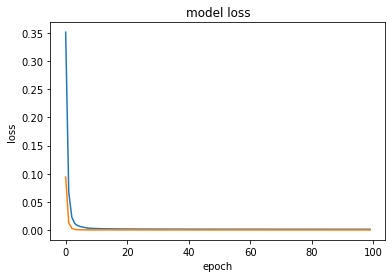

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [ ]:
%cd /content/drive/MyDrive/model

/content/drive/MyDrive/model


In [ ]:
autoencoder.save('autoencoder(0.5).model')

INFO:tensorflow:Assets written to: test(0.125).model/assets


In [ ]:
from keras.models import load_model
autoencoder=load_model('autoencoder(0.5).model')


In [ ]:
# making encoder from full autoencoder
input_signal = Input(shape=(k,))

enc = autoencoder.layers[1](input_signal)
enc1 = autoencoder.layers[2](enc)
enc2 = autoencoder.layers[3](enc1)
enc3 = autoencoder.layers[4](enc2)
enc4 = autoencoder.layers[5](enc3)
encoder = Model(input_signal, enc4)

In [ ]:
# making decoder from full autoencoder
encoded_input = Input(shape=(2*n,))

deco = autoencoder.layers[-3](encoded_input)
deco1 = autoencoder.layers[-2](deco)
deco2 = autoencoder.layers[-1](deco1)
decoder = Model(encoded_input, deco2)

In [ ]:
test_data=np.random.randint(0,2,size=(100000,k))


In [ ]:
print(test_data.shape)

(100000, 192)


## BLER

#### *Block* Error rate at a specif SNR

In [ ]:
EbNodB = 8
EbNo=10.0**(EbNodB/10.0)
noise_std = np.sqrt(1/(2*R*kmod*EbNo))
noise_mean = 0
no_errors = 0
noise = noise_std * np.random.randn(100000,2*n)
encoded_signal = encoder.predict(test_data) 
final_signal = encoded_signal + noise

In [ ]:
pred_final_signal =  decoder.predict(final_signal)

In [ ]:
bler = np.max((pred_final_signal.round()!=test_data),axis=1).mean()
print ('SNR:',EbNodB,'BLER:',bler)

SNR: 8 BLER: 0.26913


#### BLER

In [ ]:
EbNodB_range = list(frange(0,11,1))
mer = [None]*len(EbNodB_range)
for i in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[i]/10.0)
    noise_std = np.sqrt(1/(2*R*kmod*EbNo))
    noise_mean = 0
    no_errors = 0
    noise = noise_std * np.random.randn(1000000,2*n)
    encoded_signal = encoder.predict(test_data) 
    final_signal = encoded_signal + noise
    pred_final_signal =  decoder.predict(final_signal)
    #pred_output = np.where(pred_final_signal >= 0.5 , 1, 0)
    mer[i] = np.max((pred_final_signal.round()!=test_data),axis=1).mean()
    print ('SNR:',EbNodB_range[i],'MER:',mer[i])

## BER

In [ ]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

In [ ]:
EbNodB_range = list(frange(0,11,1))
ber = [None]*len(EbNodB_range)
for i in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[i]/10.0)
    noise_std = np.sqrt(1/(2*R*kmod*EbNo))
    noise_mean = 0
    no_errors = 0
    noise = noise_std * np.random.randn(100000,2*n)
    encoded_signal = encoder.predict(test_data) 
    final_signal = encoded_signal + noise
    pred_final_signal =  decoder.predict(final_signal)
    
    #pred_output = np.where(pred_final_signal >= 0.5 , 1, 0)
    ber[i] = K.mean(K.cast(K.not_equal(test_data, K.round(pred_final_signal)),dtype='float32')).numpy()
    print ('SNR:',EbNodB_range[i],'BER:',ber[i])

SNR: 0 BER: 0.02602039
SNR: 1 BER: 0.014830156
SNR: 2 BER: 0.0075160936
SNR: 3 BER: 0.0032777344
SNR: 4 BER: 0.0011934375
SNR: 5 BER: 0.00034648436
SNR: 6 BER: 8.234375e-05
SNR: 7 BER: 1.5625e-05
SNR: 8 BER: 1.875e-06
SNR: 9 BER: 0.0
SNR: 10 BER: 0.0


In [ ]:
import matplotlib.pyplot as plt
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(7,4)')
#plt.plot(list(EbNodB_range), ber_theory, 'ro-',label='BPSK BER')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)
plt.show()